Introduction

These days, there has been a push for establishing the different ways illnesses can affect men and women as most of the research done up to today has been primarily done on men. Heart disease can also have different symptoms compared to men and women, where women get less expected symptoms like jaw pain. Our study aims to recognize the biological differences between male and female patients that could affect the normal ranges of various predictors for improvement in the effective diagnosis and treatment of heart disease. These variables include disease classification, cholesterol levels, resting electrocardiogram (ECG) results, and maximum heart rate achieved. Utilizing the K-nearest neighbors classification method, we intend to predict a patient's gender based on a subset of these variables from the heart disease dataset. While the heart disease dataset encompasses a broad range of variables, our analysis will focus exclusively on these selected predictors. There will also be 303 instances of data to be used for both training and testing our data. This way, we can explore if there is enough of a difference between the variables we are using to prove that heart conditions may manifest in unique ways for each gender.

Methods

In [4]:
library(repr)
library(tidyverse)
library(rvest)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [5]:
url <- "https://raw.githubusercontent.com/victoriachoi7/group-4-dsci/main/processed.cleveland.data"
cleveland_data <- read_csv(url, col_names = FALSE)
colnames(cleveland_data) <- c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain_type,resting_bp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


From this table, we need to isolate the variables we are interested in. These columns include sex, disease classification (num), cholesterol levels (chol), resting electrocardiogram (ECG) results (rest_ecg), and maximum heart rate achieved (thalach). This is also known as the wrangling process. We mutated the sex variable to tell us female or male for clarity.

In [6]:
cleveland_wrangled <-cleveland_data|>
            select("sex", "num", "chol", "restecg", "thalach")|>
            mutate(sex = as_factor(sex)) |>
            mutate(sex = fct_recode(sex, "female" = "0", "male" = "1"))
cleveland_wrangled

sex,num,chol,restecg,thalach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
male,0,233,2,150
male,2,286,2,108
male,1,229,2,129
⋮,⋮,⋮,⋮,⋮
male,3,131,0,115
female,1,236,2,174
male,0,175,0,173


Next, we can also summarize the wrangled data to get a premilinary look at our data distribution and averages. The first part looks at the distribution between female and male data points.

In [7]:
num_obs <- nrow(cleveland_wrangled)
cleveland_obs <- cleveland_wrangled |>
        group_by(sex)|>
        summarize(count = n(), percentage = n() / num_obs * 100)
cleveland_obs

sex,count,percentage
<fct>,<int>,<dbl>
female,97,32.0132
male,206,67.9868


We see here that the percentage of male oberservations dominate the number of female observations in the data set.

Secondly, we can find the mean values of each of the variables to get a feel for how the data varies for each sex.

In [8]:
cleveland_sum <- cleveland_wrangled |>
        group_by(sex)|>
        summarize(chol_mean = mean(chol), num_mean = mean(num), restecg_mean = mean(restecg), thalach_mean = mean(thalach))
cleveland_sum

sex,chol_mean,num_mean,restecg_mean,thalach_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
female,261.7526,0.5360825,0.9587629,151.2268
male,239.6019,1.1262136,1.0048544,148.8447


Through finding the means for each testing variable, we can see what values each variable leans towards for each sex. Though num and restecg usually have integer values, we can see through the means what number most of the respective female and male population leans towards.

Finally, using the next step, we can see if there are any missing values that might end up being a problem in our data analysis.

In [9]:
cleveland_missing <- sum(is.na(cleveland_wrangled))
cleveland_missing

[1] 0

We can see that there are no missing values detected in our data. Thus, we can go ahead without any extra steps and use the wrangled data for our next steps.

Our next step will be creating a visualization to additionally explore the data we plan to analyze. We have a scatterplot made with the genders highlighted in different colours to see if there are groupings in the data for males and females for cholesterol levels vs the maximum heart rate achieved by patients. Essentially, we taking a preliminary look that may give us hint of how our "official" data analysis will go.

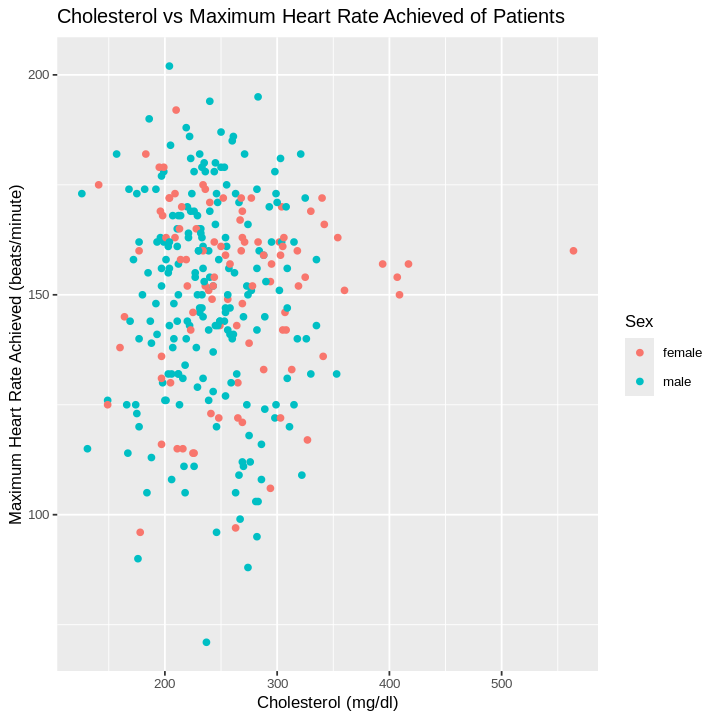

In [21]:
options(repr.plot.width = 6, repr.plot.height = 6)
cleveland_viz_1 <- cleveland_wrangled|>
        ggplot(aes(x = chol, y = thalach, colour = sex)) +
            geom_point()+
            labs(x = "Cholesterol (mg/dl)",
                 y = "Maximum Heart Rate Achieved (beats/minute)",
                 colour = "Sex")+
        ggtitle("Cholesterol vs Maximum Heart Rate Achieved of Patients")+
        theme(text = element_text(size = 10))
cleveland_viz_1

Here, we cannot see much correlation between the gender, the maximum heart rate achieved per minute, and cholesterol levels. since there is a bigger proportion of male data point though, perhaps it is better ot let the classification to decide if there is a correlation.

The next step to do after wrangling the data is to make a model of the K-nearest neighbors in order to predict the patient's gender. The first step we have to do here is to split the data into training data and testing data in order to be able to train our model while also testing it so that we can have the best possible model. In this case, we are using a seed throughout the process to create a consistent result of randomness.

In [8]:
set.seed(1234) 

cleveland_split <- initial_split(cleveland_wrangled, prop = 0.75, strata = sex)
cleveland_train <- training(cleveland_split)   
cleveland_test <- testing(cleveland_split)

Next up, we have to create the model using tune() as the neighbors parameter, so that each parameter in the model can be adjusted rather than given a specific value.

In [9]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_recipe <- recipe(sex ~ . , data = cleveland_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

Then, we have to make the the plot between the accuracy and the number of neighbors (between n = 1 to 15) so that we can decide which number of neighbors will be optimal in predicting the gender of the patients. We also made a 5 cross-validation folds which helps to validate the stability and performance of a machine learning model. It does so by training the model multiple times on different subsets of the data and testing it on the remaining parts.

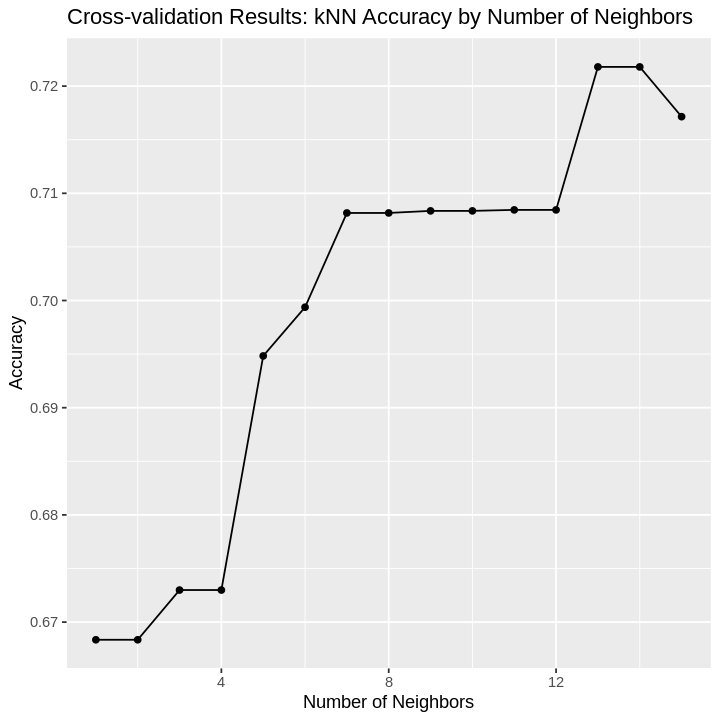

In [10]:
set.seed(1234) 

cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = sex)

grid_vals <- tibble(neighbors = seq(1, 15))

knn_results <- workflow() |>
      add_recipe(knn_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = cleveland_vfold, grid = grid_vals) |>
      collect_metrics()

accuracies <- knn_results |> 
  filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
  geom_point() + 
  geom_line() + 
  labs(x = "Number of Neighbors", y = "Accuracy", title = "Cross-validation Results: kNN Accuracy by Number of Neighbors")

cross_val_plot

As we can see, the average peaked at about 0.73 when N = 13, this shows that the optimal N nearest neighbors for the kNN model is N = 13. Therefore, we are going to make a model with N = 13.

In [11]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
      set_engine("kknn") |>
      set_mode("classification")

cleveland_fit <- workflow() |>
       add_recipe(knn_recipe) |>
       add_model(knn_spec) |>
       fit(data = cleveland_train)
cleveland_fit

predictions <- predict(cleveland_fit, cleveland_train) |>
  bind_cols(cleveland_train)

metrics <- predictions |>
  metrics(truth = sex, estimate = .pred_class) |>
  filter(.metric == "accuracy")
metrics

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.300885
Best kernel: rectangular
Best k: 13

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7389381


Here we can see that the model gives us an accuracy of 0.7389381 which is pretty good to move on to the next stage.

Now that we have a K-nearest neighbors classifier object, we can use it to predict the class labels for our test set.

In [12]:
cleveland_test_predictions <- predict(cleveland_fit, cleveland_test) |>
bind_cols(cleveland_test) |>
select(.pred_class, sex)

cleveland_test_predictions

.pred_class,sex
<fct>,<fct>
male,male
male,male
male,female
⋮,⋮
male,female
male,female
male,male


After printing out the first few columns of the predictions it made it looks pretty accurate however to understand both how good our predictive model was and how closely correlated gender and the other elements we looked at are we need more.
The first and easiest evaluation step is to make a table of how often the podel predicted vs how often it was right. This will allow us to determine if the model was overpredicting a single gender or if it is more balanced.

In [14]:
cleaveland_mat <- cleveland_test_predictions |> 
       conf_mat(truth = sex, estimate = .pred_class)
cleaveland_mat

          Truth
Prediction female male
    female      6    7
    male       19   45

Results

Discussion

From the results we can see that there is clearly a correlation as the accuracy is around 70 percent however in an article by Tapie et al.(2023) they found that gender only affects some heart health metrics in a meaningful way. This could explain our relatively low accuracy as our predictions assign some weight to statistics that can't realistically be used to determine gender and thus combine bad predictions into our results. With some scaling of the data to reflect its correlation to gender these results could likely be improved however that is outside the scope of our analysis of the topic. in addition, there is a notable problem with the data as there are significantly more males than females and thus the algorithm is better at predicting them. This greatly skews the results and means that they are far less accurate and it is harder to determine how much of the correlation is just because the algorithm picks males far more often. However, given the number of females in the sample it makes sense that the algorithm would pick males more often. When moving forward and drawing conclusions from this data it is important to remember this imbalance. Despite that, there is still evidence of some correlation and there is some level of accuracy in the results. This result is almost exactly what we expected as in our proposal we stated we expected the model to predict gender with moderate accuracy. That being said I would have hoped for a far higher accuracy to ensure that without a doubt gender is the factor that causes these changes.

Conclusion

In conclusion, we looked at the correlation between various heart metrics and gender in the data from the Cleveland area. We found that there is some definitive correlation however our model accuracy was ~74 percent which indicates that there is significant room for improvement. Future studies could look at each individual metric separately and determine if it should or should not be used to predict gender or look at different areas. Understanding the correlation between gender and heart metrics would help medical professionals give more personalized care and may even improve healthcare outcomes. This research can help contribute to improving the "gender health gap" as noted in the article by Schmitz and Lazarevič (2020). In addition, a more balanced split of male and female data would provide better results and ensure that the results are purely because of differences and not because of skewed data. Overall a better understanding of the heart and its average values is important and more work needs to be done to help improve the healthcare system.

References

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Schmitz, A., & Lazarevič, P. (2020). The gender health gap in Europe's ageing societies: universal findings across countries and age groups?. European journal of 
    ageing, 17(4), 509–520. https://doi.org/10.1007/s10433-020-00559-6

Tapia, J., Basalo, M., Enjuanes, C., Calero, E., José, N., Ruíz, M., Calvo, E., Garcimartín, P., Moliner, P., Hidalgo, E., Yun, S., Garay, A., Jiménez-Marrero, S.,
    Pons, A., Corbella, X., & Colet, J. C. (2023). Psychosocial factors partially explain gender differences in health-related quality of life in heart failure 
    patients. ESC heart failure, 10(2), 1090–1102. https://doi.org/10.1002/ehf2.14260

